# Machine Learning


From our exploratory analysis (detailed in `exploratory-analysis.ipynb`), we identified the following relations:


| Correlation                            | Categorical | Numerical               | Mixed |
|----------------------------------------|-------------|-------------------------|-------|
| Strong Positive Correlation / Relation | `domain_in_ip`, `url_shortened` | `length_url` | `qty_at_url`, `time_domain_activation`, `time_domain_expiration` |
| Strong Negative Correlation / Relation | `url_google_index`, `domain_google_index` | | |
| Weak Correlation / Relation            | `tls_ssl_certificate` | | `qty_dot_domain`, `qty_hyphen_domain` |


### Reclassifying mixed variables
Through our mixed variable analysis, we observed that `qty_at_url` functions more like a categorical variable, indicating that the presence of '@' symbol is a reliable phishing marker. On the other hand, `time_domain_activation` and `time_domain_expiration` behaved as numerical variables aligning with our initial hypothesis that phishing domains typically have shorter lifespans and closer expiration dates.

We reclassify these mixed variables into categorical or numerical variables and removed all variables with weak correlation / relation to obtain the following:

| Correlation                            | Categorical | Numerical               |
|----------------------------------------|-------------|-------------------------|
| Strong Positive Correlation / Relation | `domain_in_ip`, `url_shortened`, `qty_at_url`| `length_url`, `time_domain_activation`, `time_domain_expiration` | 
| Strong Negative Correlation / Relation | `url_google_index`, `domain_google_index` | |


In [238]:
# Open the datasets and import libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load full dataset
url_information = pd.read_csv('../datasets/url_information.csv')

# convert mixed variables to categorical (since we found that 'qty_at_url' functions better as a categorical variable)
url_information['qty_at_url'] = np.where(url_information['qty_at_url'] <= 0, 0, 1)

### Preprocessing Data (Feature Engineering)

We further engaged in feature engineering to extract a custom URL Strangeness Score (USS) that evaluates URLs based on Character Diversity Index, Domain Complexity Index, Path Complexity Index and Parameter Complexity index (as detailed in `feature-engineering.ipynb`).

##### Overall Formula:
```
USS = 15(CDI) + 35(DCI) + 20(PCI) + 30(PRCI)
```

Where:
- CDI = Character Diversity Index
- DCI = Domain Complexity Index
- PCI = Path Complexity Index
- PRCI = Parameter Complexity Index

            count       mean        std       min        25%        50%  \
phishing                                                                  
0         77546.0  10.074203   4.006790  2.424242   7.749627   9.384004   
1         52152.0  16.791299  11.448659  2.424242  10.518416  13.392403   

                75%         max  
phishing                         
0         11.559861   79.347019  
1         18.785461  146.381208  


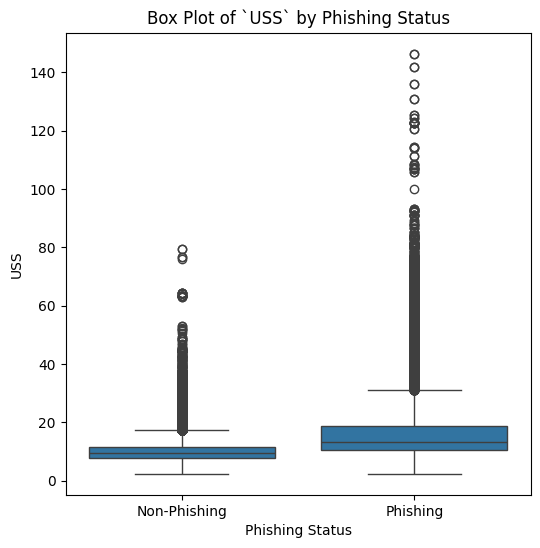

In [210]:
cdi_list = [
    'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url', 'qty_questionmark_url', 'qty_equal_url', 
    'qty_at_url', 'qty_and_url', 'qty_exclamation_url', 'qty_space_url', 'qty_tilde_url', 'qty_comma_url', 
    'qty_plus_url', 'qty_asterisk_url', 'qty_hashtag_url', 'qty_dollar_url', 'qty_percent_url'
]

dci_list = [
    'qty_dot_domain', 'qty_hyphen_domain', 'qty_underline_domain', 'domain_length', 'qty_vowels_domain'
]

pci_list = [
    'directory_length', 'qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory', 
    'file_length', 'qty_dot_file', 'qty_hyphen_file', 'qty_underline_file'
]

prci_list = [
    'params_length', 'qty_params', 'qty_equal_params', 'qty_and_params'
]

total_list = [
    cdi_list, dci_list, pci_list, prci_list
]

def normalise_columns(df, columns):
    for column in columns:
        max_value = df[column].max()
        # To avoid division by zero, check if max_value is not zero
        if max_value != 0:
            df[column + '_norm'] = df[column] / max_value
        else:
            df[column + '_norm'] = 0
    return df

def calculate_index(df, columns):
    index_sum = df[[col + '_norm' for col in columns]].sum(axis=1)
    return index_sum

def clean_data(df, columns):
    for column in columns:
        df[column] = df[column].apply(lambda x: 0 if x < 0 else x)
    return df

def displayBoxPlot(numerical_data, df):
    plt.figure(figsize=(6, 6))
    sb.boxplot(x='phishing', y=numerical_data, data=df)
    plt.title(f'Box Plot of `{numerical_data}` by Phishing Status')
    plt.xlabel('Phishing Status')
    plt.ylabel(numerical_data)
    plt.xticks([0, 1], ['Non-Phishing', 'Phishing'])
    plt.show()


# USS computatinpn and adding to information column
all_features = sum(total_list, [])
url_information = clean_data(url_information, all_features)

for feature_list in total_list:
    url_information = normalise_columns(url_information, feature_list)

CDI = calculate_index(url_information, cdi_list)
DCI = calculate_index(url_information, dci_list)
PCI = calculate_index(url_information, pci_list)
PRCI = calculate_index(url_information, prci_list)

url_information['USS'] = 15 * CDI +  35 * DCI + 20 * PCI + 30 * PRCI

summary_statistics = url_information.groupby('phishing')['USS'].describe()
print(summary_statistics)
displayBoxPlot('USS', url_information)

### Defining our Training datasets

In [231]:
# using only numerical variables
X_numerical = url_information[['length_url', 'time_domain_activation', 'time_domain_expiration']]

# using only categorical variables (has been preprocessed into numerical values)
X_categorical = url_information[['domain_in_ip', 'url_shortened', 'qty_at_url', 'url_google_index', 'domain_google_index']]

# using only featured engineered variables
X_engineered = url_information[['USS']]

# combining both numerical and categorical variables
X_num_cat = url_information[['length_url', 'time_domain_activation', 'time_domain_expiration', 'domain_in_ip', 'url_shortened', 'qty_at_url', 'url_google_index', 'domain_google_index']]

# using all
X_all = url_information[['length_url', 'time_domain_activation', 'time_domain_expiration', 'domain_in_ip', 'url_shortened', 'qty_at_url', 'url_google_index', 'domain_google_index', 'USS']]

y = url_information['phishing']

### Defining evaluation metrics

In [232]:
def evaluate_model(model, X_train, y_train, X_test, y_test, title=''):
    # Make predictions on the train and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Performing the calculations
    cm_train = confusion_matrix(y_train, y_train_pred) # Confusion Matrices
    cm_test = confusion_matrix(y_test, y_test_pred)

    accuracy_train = accuracy_score(y_train, y_train_pred) # Classification Accuracy
    accuracy_test = accuracy_score(y_test, y_test_pred)

    tpr_train = recall_score(y_train, y_train_pred, pos_label=1)  # True Positive Rate
    tpr_test = recall_score(y_test, y_test_pred, pos_label=1)

    fpr_train = 1 - recall_score(y_train, y_train_pred, pos_label=0)  # False Positive Rate, which is basically 1-TPR
    fpr_test = 1 - recall_score(y_test, y_test_pred, pos_label=0)

    plt.figure(figsize=(9, 6))
    
    plt.subplot(1, 2, 1)  # Train heatmap
    sb.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix (Train)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['Non-Phishing', 'Phishing'])
    plt.yticks([0.5, 1.5], ['Non-Phishing', 'Phishing'])

    plt.subplot(1, 2, 2)  # Test heatmap
    sb.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix (Test)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['Non-Phishing', 'Phishing'])
    plt.yticks([0.5, 1.5], ['Non-Phishing', 'Phishing'])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    print(f"Accuracy (Train): {accuracy_train:.4f}, TPR (Train): {tpr_train:.4f}, FPR (Train): {fpr_train:.4f}")
    print(f"Accuracy (Test): {accuracy_test:.4f}, TPR (Test): {tpr_test:.4f}, FPR (Test): {fpr_test:.4f}")

# Logistic Regression

In [233]:
def compute_logistic_reg(X, y, test_split=0.2, random_state=1234, title=''):
    # split the training data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=random_state)

    # logistic regression model
    model = LogisticRegression(max_iter=1000)

    # train model
    model.fit(X_train, y_train)

    # run model evaluation on confusion matrix
    evaluate_model(model, X_train, y_train, X_test, y_test, title=title)

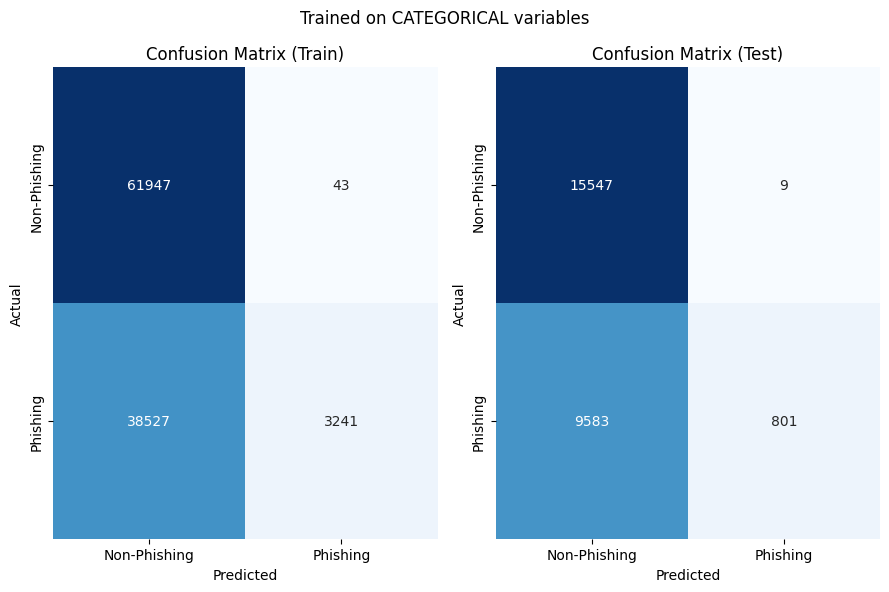

Accuracy (Train): 0.6283, TPR (Train): 0.0776, FPR (Train): 0.0007
Accuracy (Test): 0.6302, TPR (Test): 0.0771, FPR (Test): 0.0006


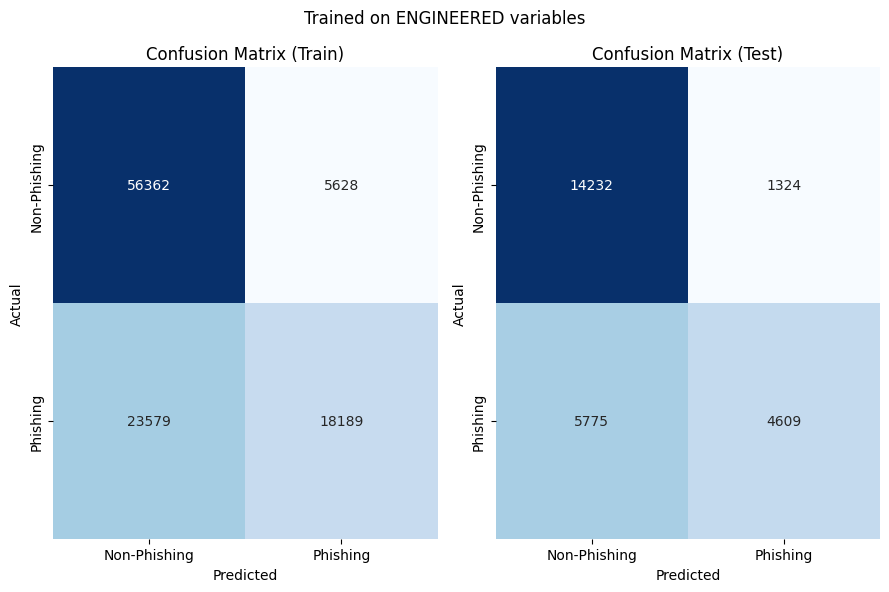

Accuracy (Train): 0.7185, TPR (Train): 0.4355, FPR (Train): 0.0908
Accuracy (Test): 0.7263, TPR (Test): 0.4439, FPR (Test): 0.0851


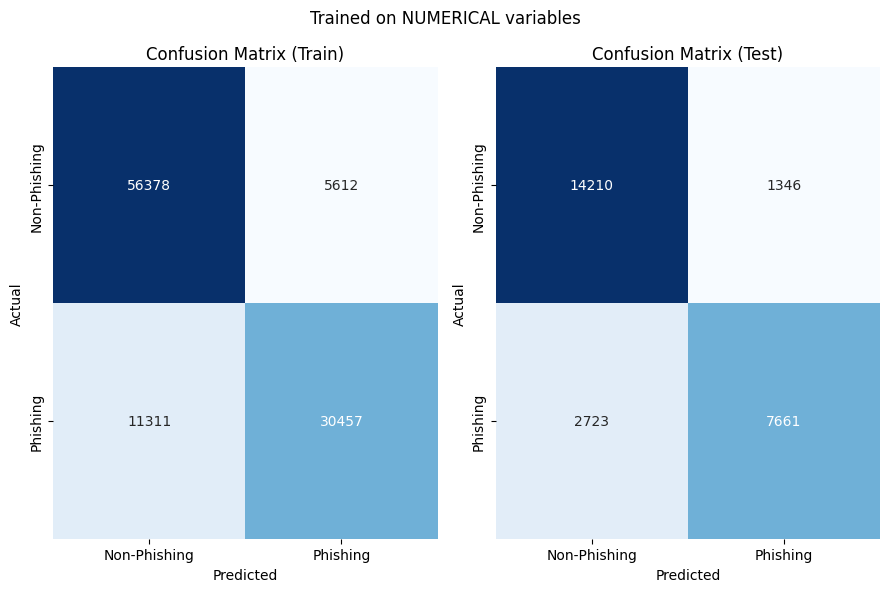

Accuracy (Train): 0.8369, TPR (Train): 0.7292, FPR (Train): 0.0905
Accuracy (Test): 0.8431, TPR (Test): 0.7378, FPR (Test): 0.0865


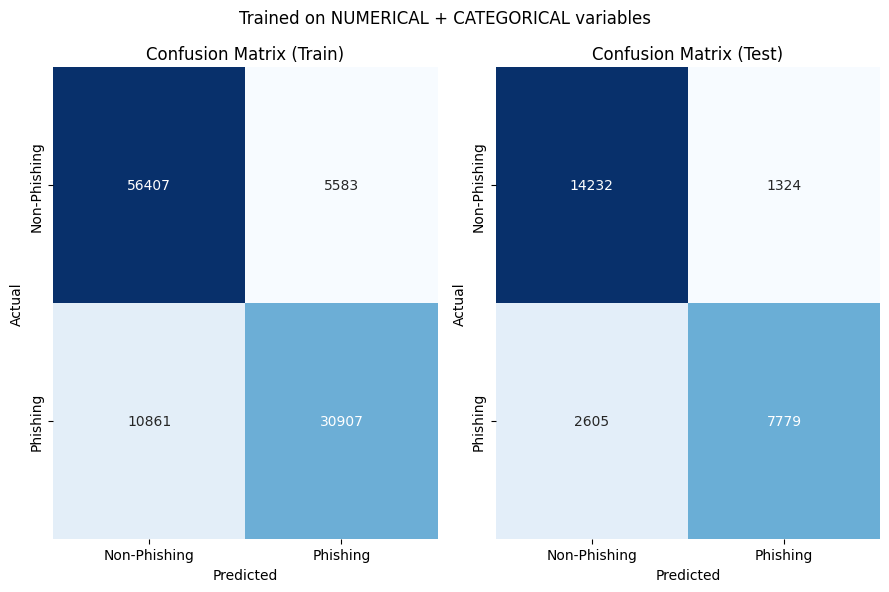

Accuracy (Train): 0.8415, TPR (Train): 0.7400, FPR (Train): 0.0901
Accuracy (Test): 0.8485, TPR (Test): 0.7491, FPR (Test): 0.0851


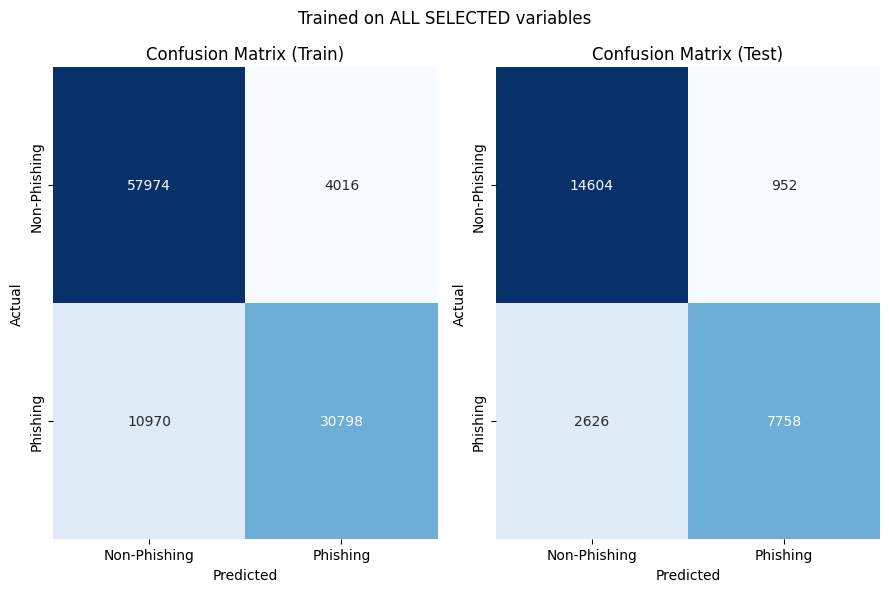

Accuracy (Train): 0.8556, TPR (Train): 0.7374, FPR (Train): 0.0648
Accuracy (Test): 0.8621, TPR (Test): 0.7471, FPR (Test): 0.0612


In [240]:
compute_logistic_reg(X_categorical, y, title='Trained on CATEGORICAL variables')
compute_logistic_reg(X_engineered, y, title='Trained on ENGINEERED variables')
compute_logistic_reg(X_numerical, y, title='Trained on NUMERICAL variables')
compute_logistic_reg(X_num_cat, y, title='Trained on NUMERICAL + CATEGORICAL variables')
compute_logistic_reg(X_all, y, title='Trained on ALL SELECTED variables')

### Logistic Regression Model Performance Comparison

As we vary our datasets used for model training, we obtain the following results:


| Metrics | Categorical Only | Engineered Only | Numerical Only | Numerical + Categorical | All Selected |
|---------|----------------|------------------|-----------------|-------------------------|--------------|
| Accuracy (Train) | 0.6283 | 0.7185 | 0.8369 |0.8415 | 0.8556 |
| TPR (Train) | 0.0776 |  0.4355 | 0.7292 | 0.7400 | 0.7374 | 
| FPR (Train) | 0.0007 | 0.0908 | 0.0905 | 0.0901 |  0.0648 | 
| Accuracy (Test) | 0.6302 | 0.7263 | 0.8431 | 0.8485 | 0.8621 | 
| TPR (Test) | 0.0771 | 0.4439 | 0.7378 | 0.7491 | 0.7471 | 
| FPR (Test) | 0.0006 | 0.0851 | 0.0865 | 0.0851 | 0.0612 |

*All selected refers to numerical + categorical + engineered


| Metrics | Categorical Only | Engineered Only | Numerical Only | Numerical + Categorical | All Selected |
|---------|------------------|-----------------|----------------|-------------------------|--------------|
| Accuracy (Test) | 0.6302 | 0.7263 | 0.8431 |0.8485 | 0.8621 | 


By analysing the accuracy on the test set, we notice that categorical and engineered data alone do not perform well while numerical data performs well in predicting phishing urls. When we combine Numerical with Categorical variables, we find a slight improvement in accuracy of the model. By further combining with our cusomt feature engineered data, the model's performance improves by around 2 to 86.2% for the logistic regression model. By combining different variables, we incrementally achieve improved accuracy.

# Decision Tree Classifier

In [236]:
def compute_decision_tree(X, y, test_split=0.2, random_state=1234, title=''):
    # split the training data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=random_state)

    # decision tree model
    model = DecisionTreeClassifier()

    # train model
    model.fit(X_train, y_train)

    # run model evaluation on confusion matrix
    evaluate_model(model, X_train, y_train, X_test, y_test, title=title)

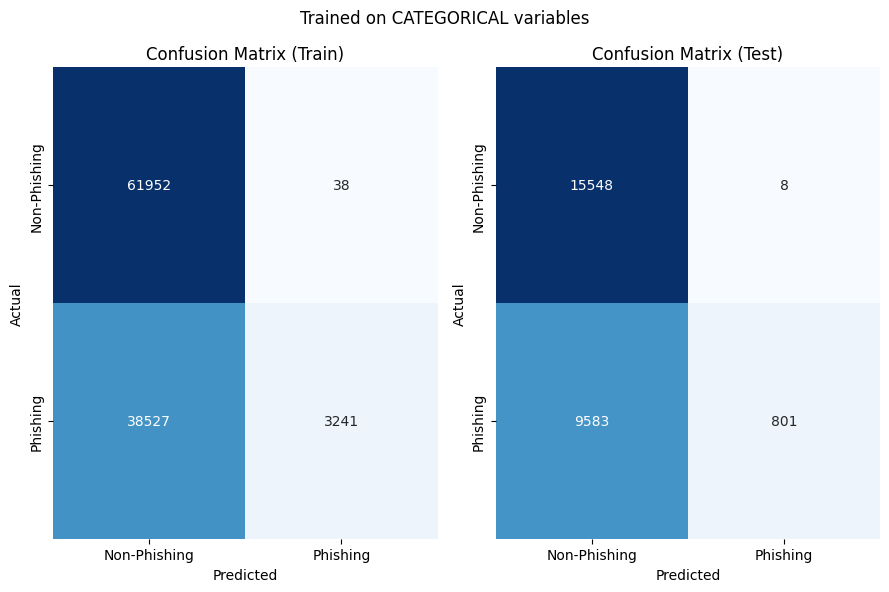

Accuracy (Train): 0.6283, TPR (Train): 0.0776, FPR (Train): 0.0006
Accuracy (Test): 0.6303, TPR (Test): 0.0771, FPR (Test): 0.0005


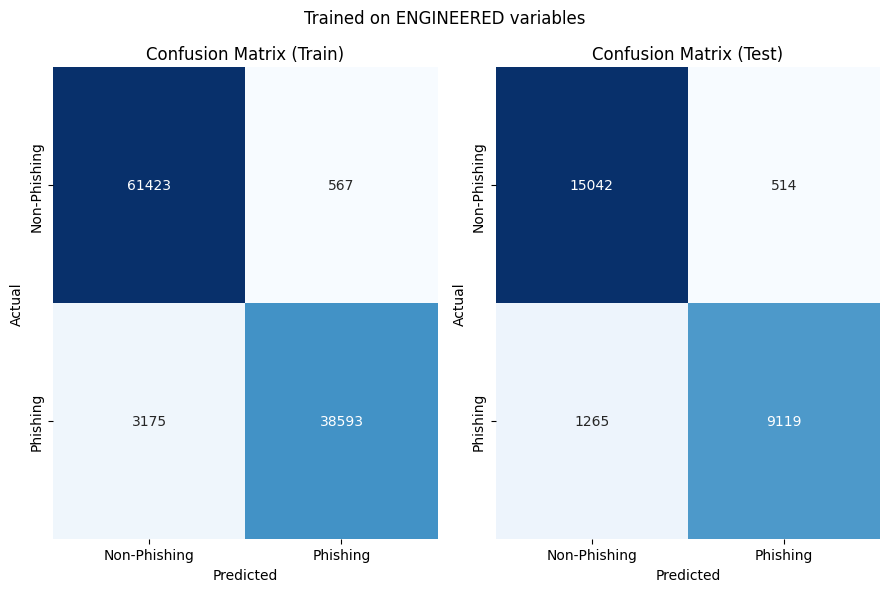

Accuracy (Train): 0.9639, TPR (Train): 0.9240, FPR (Train): 0.0091
Accuracy (Test): 0.9314, TPR (Test): 0.8782, FPR (Test): 0.0330


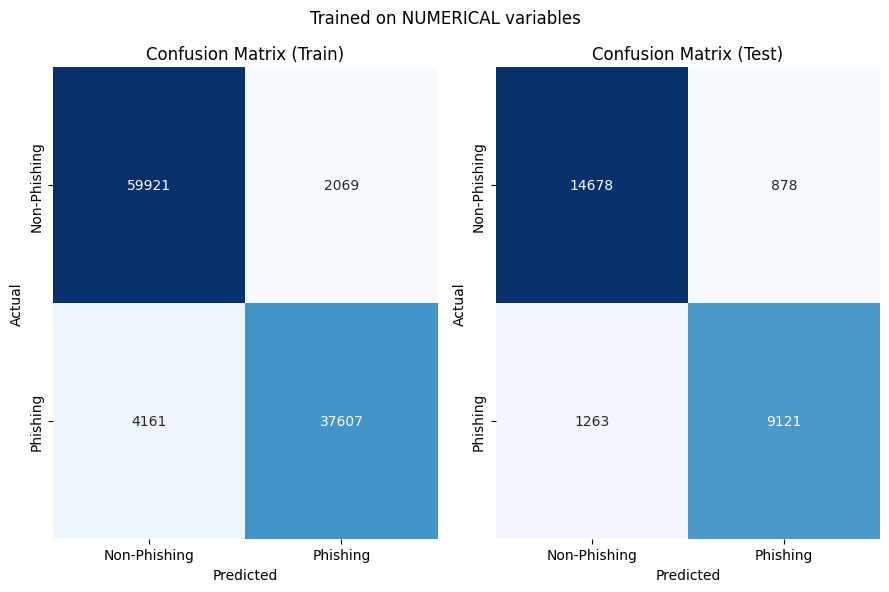

Accuracy (Train): 0.9400, TPR (Train): 0.9004, FPR (Train): 0.0334
Accuracy (Test): 0.9175, TPR (Test): 0.8784, FPR (Test): 0.0564


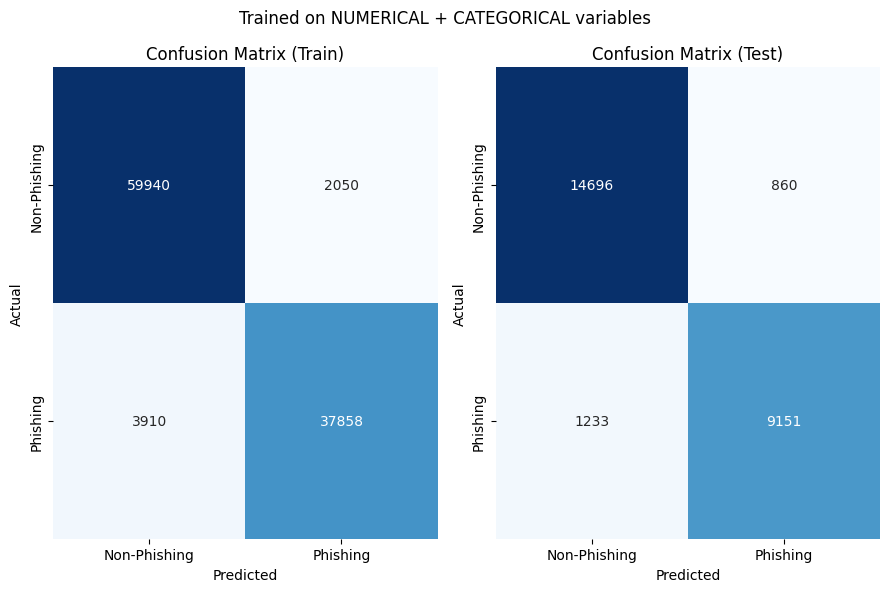

Accuracy (Train): 0.9426, TPR (Train): 0.9064, FPR (Train): 0.0331
Accuracy (Test): 0.9193, TPR (Test): 0.8813, FPR (Test): 0.0553


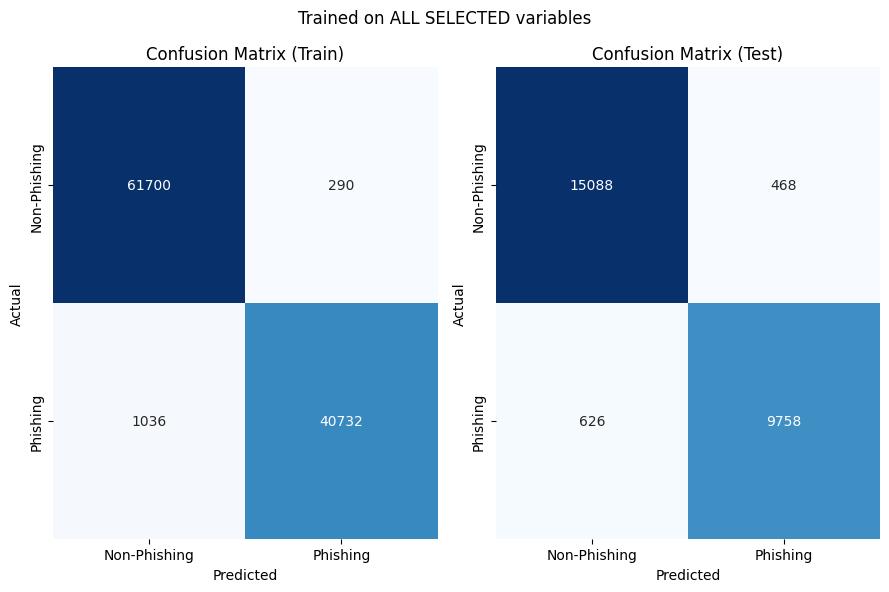

Accuracy (Train): 0.9872, TPR (Train): 0.9752, FPR (Train): 0.0047
Accuracy (Test): 0.9578, TPR (Test): 0.9397, FPR (Test): 0.0301


In [239]:
compute_decision_tree(X_categorical, y, title='Trained on CATEGORICAL variables')
compute_decision_tree(X_engineered, y, title='Trained on ENGINEERED variables')
compute_decision_tree(X_numerical, y, title='Trained on NUMERICAL variables')
compute_decision_tree(X_num_cat, y, title='Trained on NUMERICAL + CATEGORICAL variables')
compute_decision_tree(X_all, y, title='Trained on ALL SELECTED variables')

### Decision Tree Model Performance Comparison

As we vary our datasets used for model training, we obtain the following results:


| Metrics | Categorical Only | Engineered Only | Numerical Only | Numerical + Categorical | All Selected |
|---------|----------------|------------------|-----------------|-------------------------|--------------|
| Accuracy (Train) | 0.6283 | 0.9639 | 0.9400 |0.9426 | 0.9872 |
| TPR (Train) | 0.0776 |  0.9240 | 0.9004 | 0.9064 | 0.9752 | 
| FPR (Train) | 0.0006 | 0.0091 | 0.0334 | 0.0331 |  0.0047 | 
| Accuracy (Test) | 0.6303 | 0.9314 | 0.9175 | 0.9193 | 0.9578 | 
| TPR (Test) | 0.0771 | 0.8782 | 0.8784 | 0.8813 | 0.9397 | 
| FPR (Test) | 0.0005 | 0.0330 | 0.0564 | 0.0553 | 0.0301 |

*All selected refers to numerical + categorical + engineered


| Metrics | Categorical Only | Engineered Only | Numerical Only | Numerical + Categorical | All Selected |
|---------|------------------|-----------------|----------------|-------------------------|--------------|
| Accuracy (Test) | 0.6303 | 0.9314 | 0.9175 | 0.9193 | 0.9578 | 


By analysing the accuracy on the test set, we notice that categorical variables alone do not perform well. Unlike Logistic Regression, our feature engineered variable performed well by itself with a high accuracy of 93.1%. Numerical variables also perform well with an accuracy of 91.9%. When we combined numerical and categorical variables, the accuracy only increased by a slight amount to 91.9% but still remained lower than the feature engineered variable.

When we combined numerical, categorical and engineered features, we achieved the `highest accuracy of 95.8%` on the test set in identifying phishing URLs. The model also indicates a good fit with a high true positive rate of 0.9397 and low false positive rate of 0.0301.

Hence, a decision tree classifier trained on a mixed of our selected variables of different types is the most promising model in identifying phishing URLs.